In [45]:
import pandas as pd
import os
import shutil
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import librosa
import librosa.display
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#dividing to test, validation and training set
DATASET_AUDIO_PATH = "/content/archive/Data/genres_original/"

# class_names = {os.listdir(DATASET_AUDIO_PATH)}
# print("Our class names: {}".format(class_names,))

SHUFFLE_SEED = 43
VALID_and_TEST_SPLIT = 0.2
VALID_SPLIT = 0.5


BATCH_SIZE = 128
EPOCHS = 100
SAMPLING_RATE = 16000

audio_paths = [] # list of paths for every audio sample
labels = [] # classification
features = []

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccscaled = np.mean(mfccs.T, axis=0)
    
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    
    return mfccscaled

df = pd.read_csv('/content/archive/Data/features_30_sec.csv')
for index, row in df.iterrows():
  if (row['rela']=='jazz.00054.wav'):
    continue
  filepath = row['label']+"/"+row['rela']
  data = extract_features(os.path.join(DATASET_AUDIO_PATH, filepath))
  features.append([None, data, row['emotion']])


features_df = pd.DataFrame(features, columns=["file", "feature", "class_label"])

In [81]:
from sklearn import preprocessing

# 80:10:10
# Split into training, validation and test
X = np.array(features_df.feature.tolist())
y = np.array(features_df.class_label.tolist())

le = LabelEncoder()
yy = le.fit_transform(y)

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X, yy, test_size=0.2, shuffle=True, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid,  y_test_valid, test_size=0.5, shuffle=True, random_state=42)

scaler = preprocessing.StandardScaler().fit(x_train)
scaler1 = preprocessing.StandardScaler().fit(x_valid)
scaler2 = preprocessing.StandardScaler().fit(x_test)

x_train = scaler.transform(x_train)
x_valid = scaler1.transform(x_valid)
x_test = scaler2.transform(x_test)


In [87]:
# model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical


num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(40, )))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes, activation='softmax'))
# model.compile(optimizer='adam',
#                loss='sparse_categorical_crossentropy',
#                metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               5248      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 260       
Total params: 13,764
Trainable params: 13,764
Non-trainable params: 0
_________________________________________________________________


In [88]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 300
batch_size = 128

checkpointer = ModelCheckpoint(filepath="ajde.hdf5", verbose=1, save_best_only=True)

start = datetime.now()

H = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), 
          callbacks=[checkpointer], verbose=1)


train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

valid_score = model.evaluate(x_valid, y_valid, verbose=1)
print("Valid Accuracy: ", valid_score[1])




Epoch 1/300


ValueError: ignored

In [84]:
test_loss, test_acc  = model.evaluate(x_test, y_test, batch_size=128)
print("The test loss is :",test_loss, "\nThe test accuracy is :",test_acc)

1/1 [==============================] - 0s 16ms/step - loss: 1.6668 - accuracy: 0.5500
The test loss is : 1.666768193244934 
The test accuracy is : 0.550000011920929


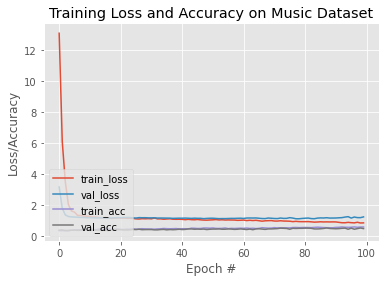

In [51]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Music Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")